In [1]:
from bokeh.models import ColumnDataSource, HoverTool, LinearAxis, Range1d, FactorRange, DataRange1d, Title
from bokeh.plotting import figure
from bokeh.io import show, output_file

import pandas as pd
import math

import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.cluster import KMeans
import sklearn.metrics as sm


df = pd.read_csv("../data/global_food_prices.csv")

In [2]:
def interpolate(values):
    for i in range(len(values)):
        if values[i] == None:
            ii = i
            x = None
            while x == None:
                ii -= 1
                if ii < 0: x = values[i]
                x = values[ii]
            ii = i
            y = None
            while y == None:
                ii -= 1
                if ii >= len(values): y = values[i]
                y = values[ii]
            values[i] = (x + y) / 2
    return values
                
def max_none(values):
    m = values[0]
    for value in values:
        if value != None and value > m:
            m = value
    return m

In [3]:
def average(x):
    return float(sum(x)) / len(x)

def correlation(x, y):
    n = len(x)
    avg_x = average(x)
    avg_y = average(y)
    dif = 0
    xdif2 = 0
    ydif2 = 0
    for i in range(n):
        xdif = x[i] - avg_x
        ydif = y[i] - avg_y
        dif += xdif * ydif
        xdif2 += xdif * xdif
        ydif2 += ydif * ydif
    return dif / math.sqrt(xdif2 * ydif2)

0.988975684705564


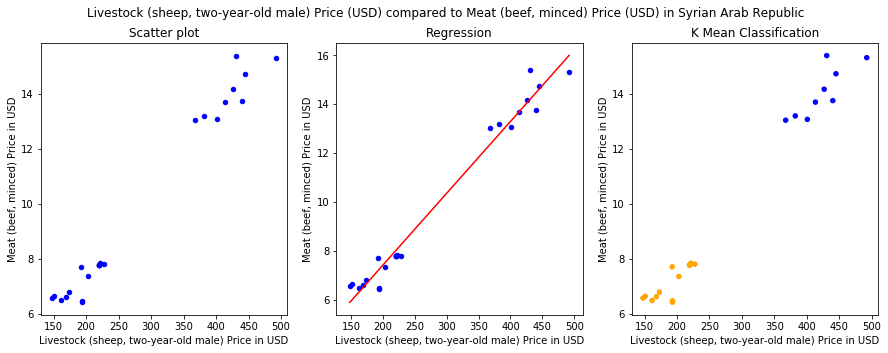

In [7]:
def product_regression(product1, product2, country, df):
    
    # Create output and right datafiles
    output_file('../graphs/Vraag1/' + country + '_correlation.html')
    df = df[(df['country']==country)]
    df1 = df[(df['product']==product1)]
    df2 = df[(df['product']==product2)]
    
    # get all common years
    years1 = sorted(list(set(df1['year'])))
    years2 = sorted(list(set(df2['year'])))
    years = []
    for year in years1:
        if year in years2:
            years.append(year)
    
    prodprice1 = []
    prodprice2 = []
    times = []
    
    # Get product prices per month
    for year in years:
        dfp1 = df[(df['year']==year) & (df['product']==product1)]
        dfp2 = df[(df['year']==year) & (df['product']==product2)]
        months = sorted(list(set(dfp1['month'])))
        for month in months:
            times.append([year, month])
            p1 = list(dfp1[(dfp1['year']==year) & (dfp1['month']==month)]['price_in_dollars'])[0]
            p1 = p1 if p1 != 'UNKNOWN' else None
            prodprice1.append(p1)
            p2 = list(dfp2[(dfp2['year']==year) & (dfp2['month']==month)]['price_in_dollars'])[0]
            p2 = p2 if p2 != 'UNKNOWN' else None
            prodprice2.append(p2)
    
    # Pair up product prices per month per year
    prodprice1 = [float(x) if x != None else None for x in prodprice1]
    prodprice2 = [float(x) if x != None else None for x in prodprice2]
    pp1 = interpolate(prodprice1)
    pp2 = interpolate(prodprice2)
    s = zip(pp1, pp2)
    s = sorted(s, key=lambda s: s[0])
    s = list(zip(*s))
    xv = list(s[0])
    yv = list(s[1])
    
    X = np.vstack(xv)
    X = np.column_stack((X, np.ones(X.shape[0])))
    Y = yv
    a, b = np.linalg.lstsq(X, Y)[0]
    xline = [a * x + b for x in xv]
    
    cor = str(round(correlation(xv, yv), 2))
    
    # Make figure
    q = figure()
    q.circle(xv, yv, size=5)
    q.y_range = DataRange1d(min(pp2), max(pp2))
    if country=='Syrian Arab Republic':
        q.title.text = 'Relation ' + product1 + ' and ' + product2 + ' prices in Syria'
    else:
        q.title.text = 'Relation ' + product1 + ' and ' + product2 + ' prices in ' + country + ' in USD'
    q.xaxis.axis_label= product1 + ' price (USD)'
    q.yaxis.axis_label= product2 + ' price (USD)'
    q.x_range = DataRange1d(min(pp1), max(pp1))
    q.line(xv, xline, color='red')
    q.toolbar.logo = None
    q.toolbar_location = None
    q.add_layout(Title(text='Correlation = ' + cor, align="center"), "below")
    show(q)
    
##############################################################################  
    
    k = pd.DataFrame()
    k['exchange'] = xv
    k['breadprice'] = yv
    
    model = KMeans(n_clusters=2)
    model.fit(k)
    model.labels_
    
    plt.figure(figsize=(15,5))
    
    subtitle = product1 + ' Price (USD) compared to ' + product2 + ' Price (USD) in ' + country
    
    plt.suptitle(subtitle)

    # Create a colormap
    colormap = np.array(['orange', 'blue'])

    # Plot the Original Classifications
    ax1 = plt.subplot(1, 3, 1)
    plt.scatter(xv, yv, c='blue', s=20)
    plt.title('Scatter plot')

    # Plot the Original Classifications
    ax2 = plt.subplot(1, 3, 2)
    plt.plot(xv, xline, c ='red')
    plt.scatter(xv, yv, c='blue', s=20)
    plt.title('Regression')

    # Plot the Models Classifications
    ax3 = plt.subplot(1, 3, 3)
    plt.scatter(xv, yv, c=colormap[model.labels_], s=20)
    plt.title('K Mean Classification')
    predY = model.labels_
    
    title1= product1 + ' Price in USD'
    title2= product2 + ' Price in USD'
    
    ax1.set_ylabel(title2)
    ax2.set_ylabel(title2)
    ax3.set_ylabel(title2)
 
    ax1.set_xlabel(title1)
    ax2.set_xlabel(title1)
    ax3.set_xlabel(title1)

    #plt.savefig('graphs/Syria_Meat_Plot.png', bbox_inches='tight')
    
    return correlation(xv, yv)

print(product_regression('Livestock (sheep, two-year-old male)', 'Meat (beef, minced)', 'Syrian Arab Republic', df))
    